In [48]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tqdm import tqdm

%matplotlib inline

In [49]:
# Load the Dataset
tensor_transform = transforms.Compose([
    transforms.ToTensor()
])

dataset = datasets.MNIST(root="./data", train=True, download=True, transform=tensor_transform)
loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=32, shuffle=True)

dataset.data.shape

torch.Size([60000, 28, 28])

In [50]:
# Collect Parameters

# Training Parameters
learning_rate = 1e-3
weight_decay = 1e-8

epochs = 20

input_size = 28


Running on the GPU


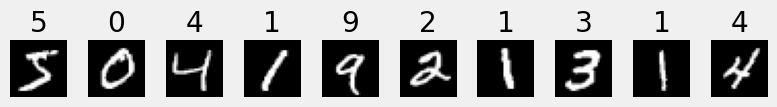

In [51]:
fig, axes = plt.subplots(1, 10, figsize=(8, 2))
for i in range(10):
    axes[i%10].imshow(loader.dataset.data[i], cmap='gray')
    axes[i%10].axis('off')
    axes[i%10].set_title(f"{loader.dataset.targets[i]}")
    
plt.tight_layout()


if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print('Running on the GPU')
else:
    device = torch.device('cpu')
    print('Running on the CPU')

In [52]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.decoder = torch.nn.Sequential(
            nn.ConvTranspose2d(64, 32, 
                               kernel_size=3, 
                               stride=2, 
                               padding=1, 
                               output_padding=1),
            nn.ReLU(),
            
            nn.ConvTranspose2d(32, 1, 
                               kernel_size=3, 
                               stride=2, 
                               padding=1, 
                               output_padding=1),
            nn.Sigmoid()
        )


    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [53]:
model = AutoEncoder()
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

Epoch 20/20: 100%|██████████| 1875/1875 [00:15<00:00, 122.87it/s, loss=0.004658]


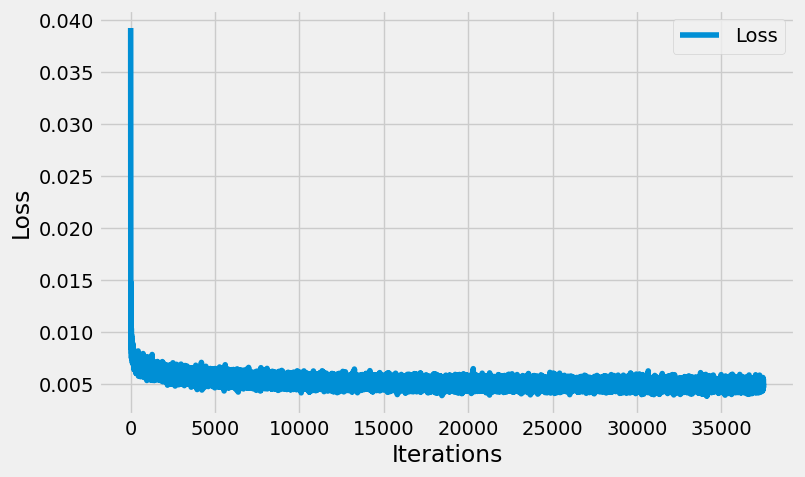

In [71]:
outputs = []
losses = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(epochs):
    with tqdm(loader, desc=f"Epoch {epoch+1}/{epochs}") as t:
        for images, _ in t:
            images = images.view(images.size(0), -1, input_size, input_size).to(device)
            def add_noise(image, noise_factor=0.3):
                noise = torch.randn_like(image) * noise_factor
                noisy_image = image + noise
                return torch.clamp(noisy_image, 0., 1.)  

            noisy_images = add_noise(images)

            reconstructed = model(noisy_images)
            loss = loss_function(reconstructed, images)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            losses.append(loss.item())
            
            t.set_postfix(loss=f"{loss.item():.6f}")

    outputs.append((epoch, images, reconstructed))
plt.style.use('fivethirtyeight')
plt.figure(figsize=(8, 5))
plt.plot(losses, label='Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()


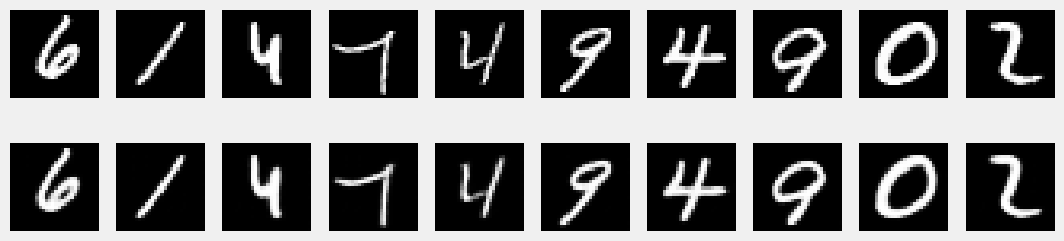

In [75]:
model.eval()
dataiter = iter(loader)
images, _ = next(dataiter)

images = images.view(images.size(0), -1, input_size, input_size).to(device)
reconstructed = model(images)

fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(12, 3))
for i in range(10):
    axes[0, i].imshow(images[i].cpu().detach().numpy().reshape(input_size, input_size), cmap='gray')
    axes[0, i].axis('off')
    axes[1, i].imshow(reconstructed[i].cpu().detach().numpy().reshape(input_size, input_size), cmap='gray')
    axes[1, i].axis('off')
plt.show()


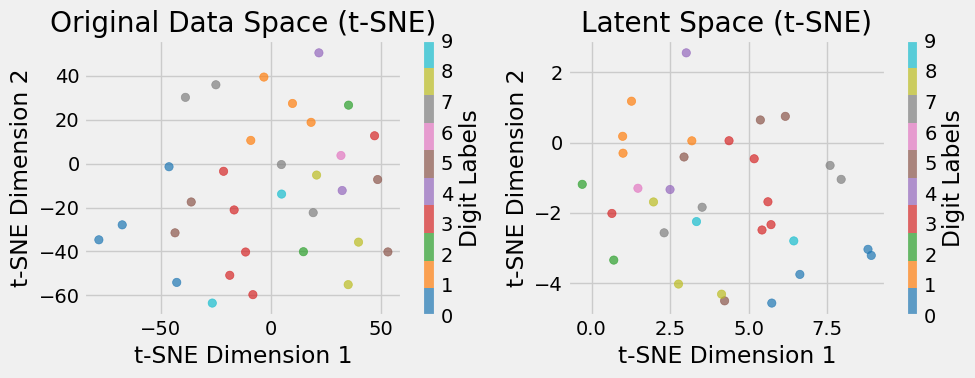

In [76]:
def visualize_latent_and_train_space(model, images, labels, input_size=28):
    device = next(model.parameters()).device
    model.eval()

    # Move data to device
    images = images.to(device)
    labels = labels.cpu().numpy()  # Ensure labels are on CPU for plotting

    with torch.no_grad():
        # Encode images into latent space
        latent_vectors = model.encoder(images.view(images.size(0), 1, input_size, input_size))
        latent_vectors = latent_vectors.view(images.size(0), -1).cpu().numpy()

    # Flatten original images for direct visualization
    train_vectors = images.view(images.size(0), -1).cpu().numpy()

    # Apply t-SNE to both latent and original spaces
    tsne = TSNE(n_components=2, random_state=42, perplexity=15)
    latent_2d = tsne.fit_transform(latent_vectors)
    train_2d = tsne.fit_transform(train_vectors)

    # Plot both visualizations side by side
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))

    # Original Data Space Visualization
    scatter2 = axs[0].scatter(train_2d[:, 0], train_2d[:, 1], c=labels, cmap='tab10', alpha=0.7)
    axs[0].set_title('Original Data Space (t-SNE)')
    axs[0].set_xlabel('t-SNE Dimension 1')
    axs[0].set_ylabel('t-SNE Dimension 2')
    plt.colorbar(scatter2, ax=axs[1], ticks=range(10), label='Digit Labels')

    # Latent Space Visualization
    scatter1 = axs[1].scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels, cmap='tab10', alpha=0.7)
    axs[1].set_title('Latent Space (t-SNE)')
    axs[1].set_xlabel('t-SNE Dimension 1')
    axs[1].set_ylabel('t-SNE Dimension 2')
    plt.colorbar(scatter1, ax=axs[0], ticks=range(10), label='Digit Labels')

    plt.tight_layout()
    plt.show()


# Get a batch of images and labels
images, labels = next(iter(loader))

# Limit to n_samples
images, labels = images[:10000], labels[:10000]

visualize_latent_and_train_space(model, images, labels)


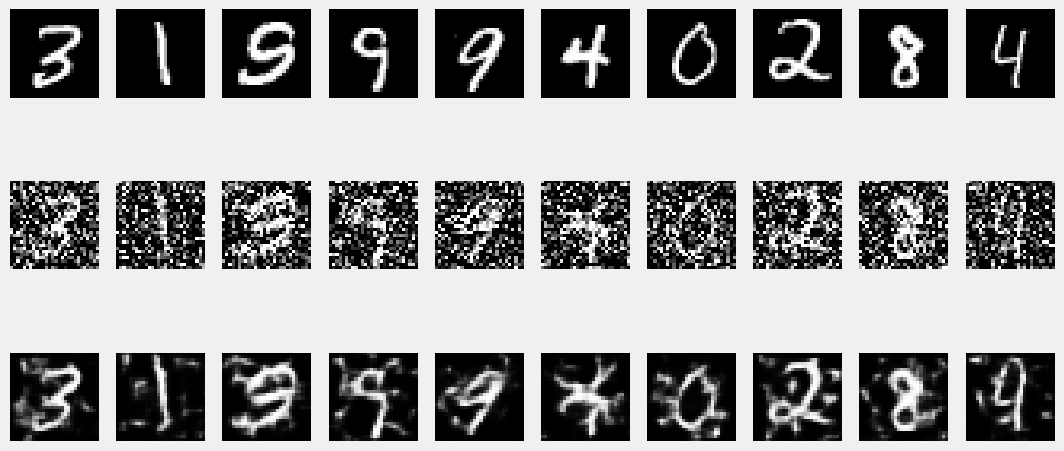

In [83]:
dataiter = iter(loader)
images, labels = next(dataiter)
noisy_images = images[:10].to(device)

def add_noise(image, noise_factor=0.6):
    noise = torch.randn_like(image) * noise_factor
    noisy_image = image + noise
    return torch.clamp(noisy_image, 0., 1.)  

noisy_images = add_noise(noisy_images)

reconstructed = model(noisy_images)

fig, axes = plt.subplots(nrows=3, ncols=10, figsize=(12, 6))
for i in range(10):
    axes[0, i].imshow(images[i].cpu().detach().numpy().reshape(input_size, input_size), cmap='gray')
    axes[0, i].axis('off')
    axes[1, i].imshow(noisy_images[i].cpu().detach().numpy().reshape(input_size, input_size), cmap='gray')
    axes[1, i].axis('off')
    axes[2, i].imshow(reconstructed[i].cpu().detach().numpy().reshape(input_size, input_size), cmap='gray')
    axes[2, i].axis('off')

plt.show()
